In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sklearn.model_selection import cross_val_score

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

# I want to read the full contents of each sentiment
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

# Functions

In [2]:
def quick_boxplot(series,title,**kwargs):
    logscale = kwargs.get('logscale',True)
    fig, ax = plt.subplots(figsize=(15,5))
    sns.boxplot(data=series,orient='h')
    plt.suptitle(title)
    if logscale:
        ax.set(xscale="log")
    plt.show()

In [3]:
def quick_histogram(series,**kwargs):
    title = kwargs.get('title','Plot of series')
    xlabel = kwargs.get('xlabel','X-axis label')
    ylabel = kwargs.get('ylabel','count')
    plt.hist(series)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [4]:
def get_tukey(df,tukey_col):
    q75, q25 = np.percentile(df[tukey_col], [75 ,25])
    iqr = q75 - q25
    tukey_dict = {}
    for threshold in np.arange(1,5.5,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
#        print("The score threshold is: {}".format(threshold))
        num_outliers = len((np.where((df[tukey_col] > max_val) | (df[tukey_col] < min_val))[0]))
#        print("Number of outliers is: {}".format(num_outliers))
        tukey_dict.update({threshold: [min_val, max_val, num_outliers]})
    return tukey_dict

## This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [5]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


house_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,None,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA

### Data cleaning, feature building

In [6]:
# Filling in missing values with 0s, or "NA"
house_df['lotfrontage'].fillna(0,inplace=True)
house_df['masvnrtype'].fillna("NA",inplace=True)
house_df['masvnrarea'].fillna(0.0,inplace=True)
house_df['bsmtqual'].fillna("NA",inplace=True) 
house_df['bsmtcond'].fillna("NA",inplace=True) 
house_df['bsmtfintype1'].fillna("NA",inplace=True) 
house_df['bsmtexposure'].fillna("NA",inplace=True) 
house_df['bsmtfintype2'].fillna("NA",inplace=True) 
house_df['fireplacequ'].fillna("NA",inplace=True)
house_df['garagetype'].fillna("NA",inplace=True) 
house_df['garageyrblt'].fillna("NA",inplace=True) 
house_df['garagefinish'].fillna("NA",inplace=True) 
house_df['garagequal'].fillna("NA",inplace=True) 
house_df['garagecond'].fillna("NA",inplace=True)

In [7]:
# Dropping poorly populated or irrelevant variables
house_df.drop(columns=['id','alley','electrical','poolqc','fence','miscfeature'],inplace=True)

Which variables are categorical? Let's blow them out into one-hot dummy variables.

In [8]:
for categorical in house_df.describe(exclude=np.number).columns:
    house_df = pd.concat([house_df, pd.get_dummies(house_df[categorical],drop_first=True,prefix=categorical)], axis=1)

__Transformations and features!__

Performing a log transformation on lot area helps make this distribution look more normal. Let's run with that.

Some of the dataframe columns can be summarized with a single dummy feature, indicating whether or not a house has a particular feature.

In [9]:
house_df['log_lotarea'] = np.log(house_df['lotarea'])

In [10]:
house_df['has_porch'] = ((house_df['openporchsf'] > 0) | (house_df['enclosedporch'] > 0) | (house_df['threessnporch'] > 0) | (house_df['screenporch'] > 0)).map({True: 1, False: 0})
house_df['has_deck'] = (house_df['wooddecksf'] > 0).map({True: 1, False: 0})
house_df['has_centralair'] = (house_df['centralair'].map({'Y': 1, 'N': 0}))
house_df['last_remodeled'] = 2019 - house_df['yearremodadd']

Figure out which variables are the most highly correlated to saleprice--we can start with this list, and whittle it down by following the guidelines for meeting the assumptions of linear regression.

In [11]:
overall_correlation = house_df.corr()

In [12]:
correlated_columns = overall_correlation['saleprice'].sort_values(ascending=False).head(20).index

In [13]:
corr_col_corr = house_df[correlated_columns].corr()

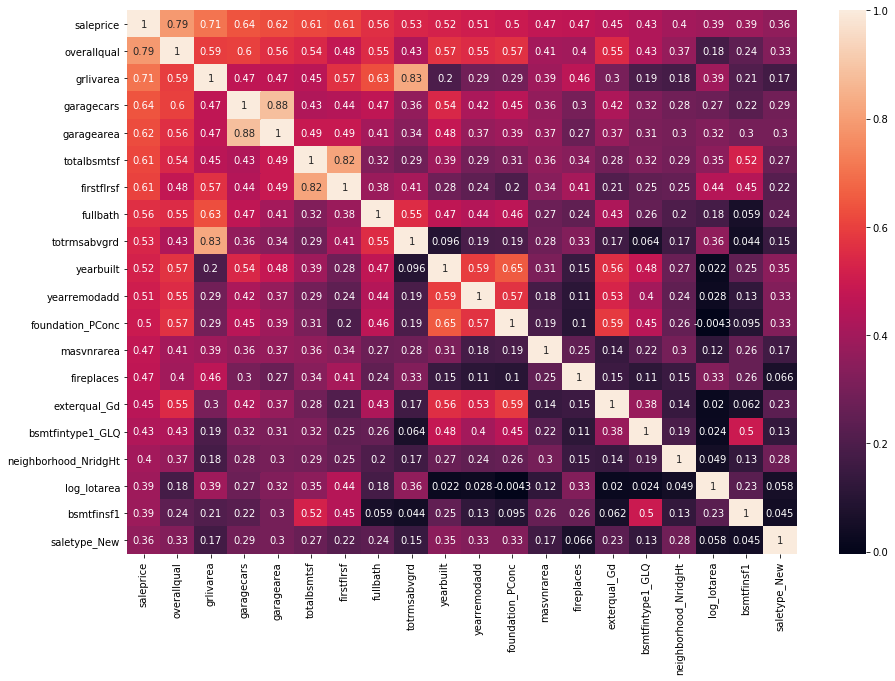

In [14]:
fig=plt.figure(figsize=(15,10))
sns.heatmap(corr_col_corr,annot=True)

__Reducing the list of features:__
* overallqual is highly correlated to too many of the other features. I don't want to use it.
* garagecars and garagearea are highly correlated. Use just garagecars.
* totrmsabvgrd is too close to grlivarea, so don't use it.
* firstflsf and totalbsmtsf are highly correlated. Drop firstflsf.
* bsmtfinsf1 is close to totalbsmtsf. Drop it.

__Start with this list:__
* grlivarea
* garagecars
* totalbsmtsf
* fullbath
* yearbuilt
* yearremodadd
* foundation_PConc
* masvnrarea
* fireplaces
* exterqual_Gd
* bsmtfintype1_GLQ
* neighborhood_NridgHt
* log_lotarea
* saletype_New

We will probably further reduce this list after seeing how significant these features are (or rather, aren't).

In [97]:
# Start with these features of interest. 
# I commented out the features that turned out to be insignificant, so you can see which ones were dropped.
vars_of_interest = ['grlivarea', 'garagecars', 'totalbsmtsf', 'yearbuilt', #'yearremodadd',
                    'exterqual_Gd', 'fireplaces', 'bsmtfintype1_GLQ', #'masvnrarea', 'foundation_PConc', 
                    'log_lotarea', 'neighborhood_NridgHt',  #'bsmtfinsf1', 'fullbath', 'saletype_New', 
                   ]
import copy
int_plus_saleprice = copy.deepcopy(vars_of_interest)
int_plus_saleprice.append('saleprice')

# Create a copy of the dataframe that's just these variables--it'll be easier to manage/manipulate
house_interest_df = house_df[int_plus_saleprice]
house_interest_df.head()

,grlivarea,garagecars,totalbsmtsf,yearbuilt,exterqual_Gd,fireplaces,bsmtfintype1_GLQ,log_lotarea,neighborhood_NridgHt,saleprice
0,1710,2,856,2003,1,0,1,9.041922,0,208500
1,1262,2,1262,1976,0,1,0,9.169518,0,181500
2,1786,2,920,2001,1,1,1,9.328123,0,223500
3,1717,3,756,1915,0,1,0,9.164296,0,140000
4,2198,3,1145,2000,1,1,1,9.565214,0,250000


In [98]:
vars_of_interest

['grlivarea',
 'garagecars',
 'totalbsmtsf',
 'yearbuilt',
 'exterqual_Gd',
 'fireplaces',
 'bsmtfintype1_GLQ',
 'log_lotarea',
 'neighborhood_NridgHt']

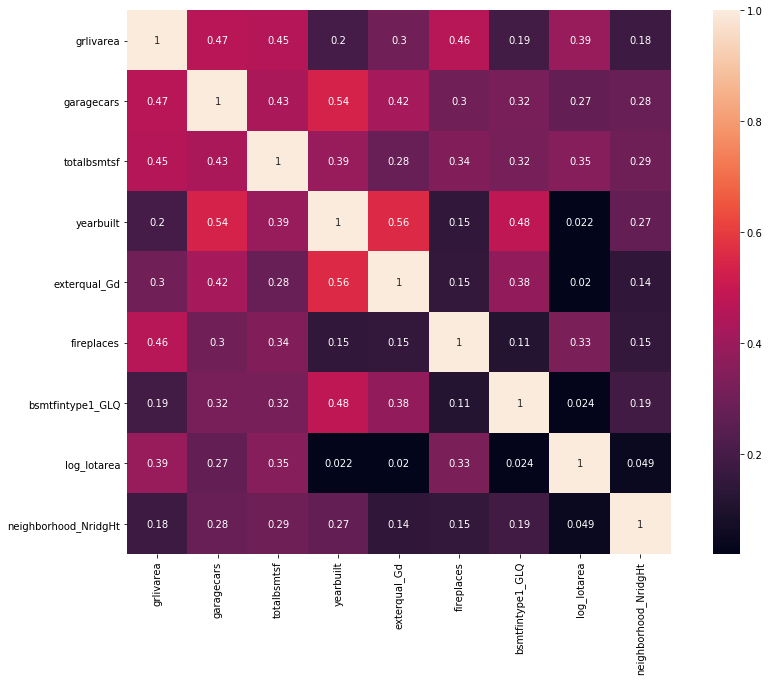

In [99]:
fig=plt.figure(figsize=(15,10))
sns.heatmap(house_interest_df[vars_of_interest].corr(),annot=True,square=True)

## Reimplement your model from the previous checkpoint.

__NOTE:__ Performing a log transformation on the dependent variable (home sale price) made its distribution much more normal, and made the model fit better.

In [100]:
# Y is the target variable
Y = np.log(house_interest_df['saleprice'])

# X is the feature set.
X = house_interest_df[vars_of_interest]

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [102]:
# We add constant to the model as it's a best practice
# to do so every time!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     505.9
Date:                Sun, 04 Aug 2019   Prob (F-statistic):               0.00
Time:                        22:29:40   Log-Likelihood:                 353.70
No. Observations:                1168   AIC:                            -687.4
Df Residuals:                    1158   BIC:                            -636.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.4459      0.504      8.816      0.000       3.456       5.435
grlivarea                0.0003   1.32e-05     20.141      0.000       0.000       0.000
garagecars               0.0984      0.010     10.203      0.000       0.079       0.117
totalbsmtsf           8.573e-05   1.49e-05      5.739      0.000    5.64e-05       0.000
yearbuilt                0.0030      0.000     12.084      0.000       0.003       0.003
exterqual_Gd             0.0846      0.014      6.015      0.000       0.057       0.112
fireplaces               0.0772      0.009      8.226      0.000       0.059       0.096
bsmtfintype1_GLQ         0.0847      0.014      6.199      0.000       0.058       0.111
log_lotarea              0.0953      0.012      8.174      0.000       0.072       0.118
neighborhood_NridgHt     0.1579      0.024      6.465      0.000       0.110       0.206
==============================================================================
Omnibus:                      731.460   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21805.221
Skew:                          -2.383   Prob(JB):                         0.00
Kurtosis:                      23.624   Cond. No.                     2.63e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

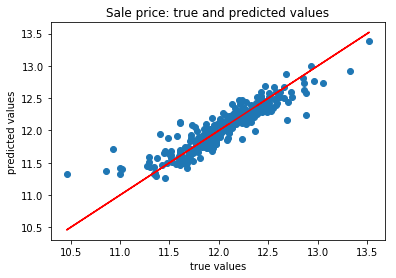

Mean absolute error of the prediction is: 0.12037581143793097
Mean squared error of the prediction is: 0.029014012716681564
Root mean squared error of the prediction is: 0.17033500144327812
Mean absolute percentage error of the prediction is: 1.008449224254358


In [103]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sale price: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

## Try OLS, Lasso, Ridge, and ElasticNet regression using the same model specification. This time, you need to do k-fold cross-validation to choose the best hyperparameter values for your models. Which model is the best? Why?

In [32]:
def kfold_xval(model,train_data,target_data):
    print("Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:")
    cross_val_array = cross_val_score(model, train_data, target_data, cv=10)
    print(cross_val_array)

In [104]:
# I learned that the estimator object (first parameter) needs to be from the sklearn module--
# I can't use sm.OLS. :)
kfold_xval(LinearRegression(),X,Y)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.81957809 0.85012414 0.8519278  0.75116459 0.82530735 0.82102813
 0.81022536 0.80425533 0.50565253 0.8504114 ]


In [87]:
def normalize(df,**kwargs):
    convert_cols = kwargs.get('convert_cols',df.columns)
    result = df.copy(deep=True)
    for feature_name in convert_cols:
        try:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        except TypeError:
            print("Skipping non-numerical column {}".format(feature_name))
    return result

In [89]:
small_house_interest_df = normalize(house_interest_df)

In [90]:
small_house_interest_df

,grlivarea,garagecars,totalbsmtsf,yearbuilt,yearremodadd,exterqual_Gd,fireplaces,bsmtfintype1_GLQ,log_lotarea,neighborhood_NridgHt,saleprice
0,0.259231,0.50,0.140098,0.949275,0.883333,1.0,0.000000,1.0,0.366344,0.0,0.241078
1,0.174830,0.50,0.206547,0.753623,0.433333,0.0,0.333333,0.0,0.391317,0.0,0.203583
2,0.273549,0.50,0.150573,0.934783,0.866667,1.0,0.333333,1.0,0.422359,0.0,0.261908
3,0.260550,0.75,0.123732,0.311594,0.333333,0.0,0.333333,0.0,0.390295,0.0,0.145952
4,0.351168,0.75,0.187398,0.927536,0.833333,1.0,0.333333,1.0,0.468761,0.0,0.298709
5,0.193670,0.50,0.130278,0.876812,0.750000,0.0,0.000000,1.0,0.466761,0.0,0.150118
6,0.256217,0.50,0.275941,0.956522,0.916667,1.0,0.333333,1.0,0.400943,0.0,0.377864
7,0.330821,0.50,0.181178,0.731884,0.383333,0.0,0.666667,0.0,0.406643,0.0,0.229274
8,0.271289,0.50,0.155810,0.427536,0.000000,0.0,0.666667,0.0,0.303205,0.0,0.131926
9,0.139977,0.25,0.162193,0.485507,0.000000,0.0,0.666667,1.0,0.340903,0.0,0.115401


In [93]:
# Y is the target variable
Y = np.log(small_house_interest_df['saleprice'])

# X is the feature set.
X = small_house_interest_df[vars_of_interest]

In [114]:
from sklearn.linear_model import HuberRegressor
kfold_xval(HuberRegressor(),X_train,y_train)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.61657608 0.83079172 0.85283142 0.80482891 0.83244737 0.78663647
 0.46106387 0.86568814 0.80534927 0.81692752]


# I STOPPED HERE 2019/08/04. Everything past this point is old.

__Moving on for now, here is Ridge:__

I started with `alpha=10**1` and kept increasing the exponent, until the folds reported back numbers that are reasonably close to each other. Above and below `10**9`, one of the folds was consistently a lot lower than the others. Further tuning to `10.5**9` brought the $R^2$ values down, but also brought them to within 5% of each other.

In [108]:
from sklearn.linear_model import Ridge
kfold_xval(Ridge(alpha=10.5**9),X_train,y_train)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.13394467 0.18540723 0.16859182 0.15981076 0.1693453  0.16264321
 0.13773682 0.15672455 0.150738   0.13316366]


In [109]:
kfold_xval(Ridge(),X_train,y_train)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.71892465 0.85031431 0.84308749 0.81944314 0.84356867 0.80257166
 0.60568149 0.84362723 0.80030455 0.82024401]


These $R^2$ values seem terrible, but the lesson material suggests this may be okay? How does this look with the full test set?

In [50]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=10**9) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.2353258326159975
-----Test set statistics-----
R-squared of the model on the test set is: 0.2402439295694199
Mean absolute error of the prediction is: 0.27261492894099276
Mean squared error of the prediction is: 0.12668771541344503
Root mean squared error of the prediction is: 0.35593217810903954
Mean absolute percentage error of the prediction is: 2.2686505847531975


__LASSO:__

Again, just manually increasing the exponent, `alpha=11**2` seems to offer consistent results across folds.

In [101]:
from sklearn.linear_model import Lasso
kfold_xval(Lasso(alpha=11**2),X_train,y_train)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.12444902 0.14665907 0.14034476 0.14524938 0.14611931 0.13687134
 0.13640442 0.1363817  0.15018645 0.12526164]


In [110]:
kfold_xval(Lasso(),X_train,y_train)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.60059154 0.8122855  0.78622001 0.72286138 0.75521339 0.76357978
 0.40431533 0.77774418 0.72058753 0.72158945]


In [102]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
lassoregr = Lasso(alpha=11**2) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.2508668834811152
-----Test set statistics-----
R-squared of the model on the test set is: 0.25873144987397634
Mean absolute error of the prediction is: 0.29082969119307855
Mean squared error of the prediction is: 0.14220233067640484
Root mean squared error of the prediction is: 0.3770972429976184
Mean absolute percentage error of the prediction is: 2.4199132878166734


__ElasticNet:__

I played with values of alpha until I saw the scores become reasonably close, and ultimately stuck with `12**2`. For further tuning I tried different values for l1_ratio and finally decided upon `.8`, meaning `alpha1=12**2 * .8` and `alpha2=12**2 * (1 - .8)=12**2 * .2`

In [97]:
from sklearn.linear_model import ElasticNet

from sklearn.linear_model import Lasso
kfold_xval(ElasticNet(alpha=12**2,l1_ratio=.8),X_train,y_train)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.14914526 0.18648919 0.17566589 0.17777758 0.18467608 0.17049243
 0.16380191 0.16633254 0.17710276 0.15026132]


In [111]:
kfold_xval(ElasticNet(),X_train,y_train)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.60940747 0.80831257 0.78868217 0.73517569 0.76440422 0.76500513
 0.41677444 0.78632506 0.73089551 0.72098178]


In [98]:
elasticregr = ElasticNet(alpha=12**2, l1_ratio=.8) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.17583043713418312
-----Test set statistics-----
R-squared of the model on the test set is: 0.17987368085913602
Mean absolute error of the prediction is: 0.2843511584289848
Mean squared error of the prediction is: 0.13675432650838878
Root mean squared error of the prediction is: 0.36980309153438506
Mean absolute percentage error of the prediction is: 2.3661965564943137
